# Lab 6 — Pix2Pix (GAN-Based Image-to-Image Translation)

This notebook implements Pix2Pix using:
- U-Net Generator
- PatchGAN Discriminator
- Adversarial + L1 Loss

Dataset: CIFAR-10 (Edge → Real Image translation)

In [14]:
!pip install tensorflow matplotlib

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

## Dataset Preparation

We use CIFAR-10 dataset.

Input: Edge-detected image  
Target: Original RGB image  

This creates paired training data for Pix2Pix.

In [16]:
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

print("Train shape:", x_train.shape)

Train shape: (50000, 32, 32, 3)


In [17]:
def create_edges(images):
    images = images.astype("float32") / 255.0
    gray = tf.image.rgb_to_grayscale(images)
    edges = tf.image.sobel_edges(gray)
    edges = tf.reduce_mean(tf.abs(edges), axis=-1)
    edges = tf.image.grayscale_to_rgb(edges)
    return edges.numpy()

edge_train = create_edges(x_train)
edge_test = create_edges(x_test)
edge_train = tf.cast(edge_train, tf.float32)
x_train = tf.cast(x_train, tf.float32)

print("Edge shape:", edge_train.shape)

Edge shape: (50000, 32, 32, 3)


In [18]:
def normalize(images):
    images = tf.cast(images, tf.float32)
    return (images * 2.0) - 1.0

x_train = normalize(x_train / 255.0)
x_test = normalize(x_test / 255.0)
edge_train = normalize(edge_train)
edge_test = normalize(edge_test)

## U-Net Generator

The Generator uses:
- Downsampling blocks (Encoder)
- Upsampling blocks (Decoder)
- Skip connections to preserve spatial details

In [19]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(layers.BatchNormalization())

    result.add(layers.LeakyReLU())

    return result

In [20]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=2,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))

    result.add(layers.BatchNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [21]:
def build_generator():
    inputs = layers.Input(shape=[32,32,3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
    ]

    up_stack = [
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs
    skips = []

    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    outputs = last(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

generator = build_generator()
generator.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 16, 16,    │      3,072 │ input_layer_9[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 8, 8, 128) │    131,584 │ sequential_8[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 4, 4, 256) │    525,312 │ sequential_9[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 8, 8, 128) │    524,800 │ sequential_10[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 8, 8, 256) │          0 │ sequential_11[0]… │
│ (Concatenate)       │                   │            │ sequential_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_12       │ (None, 16, 16,    │    262,400 │ concatenate_3[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 16, 16,    │          0 │ sequential_12[0]… │
│ (Concatenate)       │ 128)              │            │ sequential_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 32, 32, 3) │      6,147 │ concatenate_4[0]… │
│ (Conv2DTranspose)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,453,315 (5.54 MB)

 Trainable params: 1,452,163 (5.54 MB)

 Non-trainable params: 1,152 (4.50 KB)

## PatchGAN Discriminator

The Discriminator:
- Takes (input_image, target_image)
- Classifies small patches as real or fake
- Encourages sharp textures and local realism

In [22]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[32,32,3], name='input_image')
    tar = layers.Input(shape=[32,32,3], name='target_image')

    x = layers.Concatenate()([inp, tar])  # conditional GAN

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = build_discriminator()
discriminator.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 32, 32, 6) │          0 │ input_image[0][0… │
│ (Concatenate)       │                   │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 16, 16,    │      6,144 │ concatenate_5[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_14       │ (None, 8, 8, 128) │    131,584 │ sequential_13[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 4, 4, 256) │    525,312 │ sequential_14[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 6, 6, 256) │          0 │ sequential_15[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 3, 3, 512) │  2,097,152 │ zero_padding2d_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 512) │      2,048 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_13      │ (None, 3, 3, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 5, 5, 512) │          0 │ leaky_re_lu_13[0… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 2, 2, 1)   │      8,193 │ zero_padding2d_3… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

## Loss Functions

Generator Loss:
- Adversarial Loss (Binary Crossentropy)
- L1 Reconstruction Loss

Discriminator Loss:
- Real vs Fake classification loss

In [23]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Training Step

For each batch:
1. Generate fake image
2. Train Discriminator (real vs fake)
3. Train Generator (fool discriminator + L1 loss)

In [25]:
@tf.function
def train_step(input_image, target):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

    return gen_loss, disc_loss

In [26]:
EPOCHS = 5
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((edge_train, x_train))
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    for input_image, target in train_dataset:
        g_loss, d_loss = train_step(input_image, target)

    print("Generator Loss:", g_loss.numpy(),
          "Discriminator Loss:", d_loss.numpy())

Epoch 1/5
Generator Loss: 41.673817 Discriminator Loss: 0.6285151
Epoch 2/5
Generator Loss: 52.485542 Discriminator Loss: 0.20366533
Epoch 3/5
Generator Loss: 46.99995 Discriminator Loss: 0.9381381
Epoch 4/5
Generator Loss: 47.972076 Discriminator Loss: 0.99051654
Epoch 5/5
Generator Loss: 52.196655 Discriminator Loss: 0.0027790435


## Generating Translated Images

We now generate images using the trained Pix2Pix Generator.

We will compare:
- Input Edge Image
- Ground Truth Image
- Pix2Pix Output

In [27]:
sample_input = edge_test[:5]
sample_target = x_test[:5]

prediction = generator(sample_input, training=False)

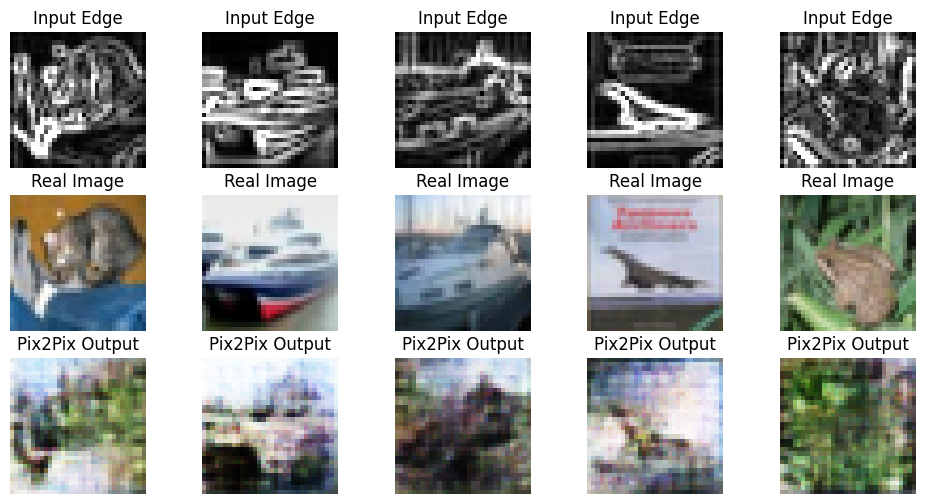

In [28]:
def denormalize(img):
    return (img + 1) / 2

plt.figure(figsize=(12,6))

for i in range(5):
    # Input (Edge)
    plt.subplot(3,5,i+1)
    plt.imshow(denormalize(sample_input[i]))
    plt.title("Input Edge")
    plt.axis("off")

    # Ground Truth
    plt.subplot(3,5,i+6)
    plt.imshow(denormalize(sample_target[i]))
    plt.title("Real Image")
    plt.axis("off")

    # Generated
    plt.subplot(3,5,i+11)
    plt.imshow(denormalize(prediction[i]))
    plt.title("Pix2Pix Output")
    plt.axis("off")

plt.show()

## Performance Comparison — Baseline CNN vs Pix2Pix

| Feature | Baseline CNN | Pix2Pix GAN |
|----------|-------------|-------------|
| Architecture | Encoder–Decoder | U-Net + PatchGAN |
| Loss | L1 / MSE | Adversarial + L1 |
| Output Quality | Blurry | Sharper |
| Texture Realism | Poor | Improved |
| Detail Preservation | Limited | Better |

Pix2Pix produces sharper and more realistic images compared to the baseline CNN.

## Why Pix2Pix Produces Sharper Images

1. Adversarial Loss encourages realism.
2. PatchGAN forces local texture accuracy.
3. U-Net skip connections preserve spatial details.
4. L1 loss ensures structural similarity.

This combination reduces blur and improves texture sharpness.

## Conclusion

Pix2Pix significantly improves image-to-image translation quality compared to a simple encoder–decoder CNN.

GAN-based training forces the generator to produce realistic, sharp images instead of average pixel reconstructions.

This experiment demonstrates the power of adversarial learning in generative models.